NOTEBOOK NOT FINISHED YET. CUDA IMPLEMENTATION needs more work.
Define a wrapper function for timing runs.

In [37]:
import cudf
import numpy as np
from cuml.datasets import make_blobs
from cuml.neighbors import NearestNeighbors as cuNearestNeighbors
from sklearn.neighbors import NearestNeighbors as skNearestNeighbors
import argparse, numpy as np, pandas as pd, timeit, os, subprocess
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def load_LAS(las_fname, dtype='float32'):
    """
    Load LAS or LAZ file (only coordinates) and return pc_xyz and xy vectors. Converts float64 to float32 by default, unless you set dtype='float64'
    """
    from laspy.file import File

    inFile = File(las_fname, mode='r')
    pc_pc_xyz = np.vstack((inFile.get_x()*inFile.header.scale[0]+inFile.header.offset[0], inFile.get_y()*inFile.header.scale[1]+inFile.header.offset[1], inFile.get_z()*inFile.header.scale[2]+inFile.header.offset[2])).transpose()

    #setting datatype to float32 to save memory.
    if dtype == 'float32':
        pc_pc_xyz = pc_pc_xyz.astype('float32')
    return pc_pc_xyz

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped


In [3]:
#Load in data
lasfname = 'test_data/Pozo_WestCanada_clg.laz'
print('Loading input file: %s... '%lasfname, end='', flush=True)
pc_xyz = load_LAS(lasfname, dtype='float32')
mean_x = np.nanmean(pc_xyz[:,0])
mean_y = np.nanmean(pc_xyz[:,1])
mean_z = np.nanmean(pc_xyz[:,2])
#subtracting mean value to center around 0 - UTM coordinates tend to be large!
pc_xyz[:,0] = pc_xyz[:,0] - mean_x
pc_xyz[:,1] = pc_xyz[:,1] - mean_y
pc_xyz[:,2] = pc_xyz[:,2] - mean_z
print('loaded %s points'%"{:,}".format(pc_xyz.shape[0]))


Loading input file: test_data/Pozo_WestCanada_clg.laz... loaded 3,348,668 points


Using cKDTree to calculate neighborhood - define functions: 

In [6]:
def pc_generate_cKDTree(pc_xyz, leafsizei=10):
    try:
        from scipy import spatial
    except ImportError:
        raise pc_generate_cKDTree("scipy not installed.")
    pc_xyz_cKDTree_tree = spatial.cKDTree(pc_xyz, leafsize=leafsizei)
    return pc_xyz_cKDTree_tree

def pc_query_cKDTree(pc_xyz_cKDTree_tree, pc_xyz, k=10):
    pc_cKDTree_distance, pc_cKDTree_id = pc_xyz_cKDTree_tree.query(pc_xyz, k=k, n_jobs=-1)
    return pc_cKDTree_distance, pc_cKDTree_id

Generate cKDTree and get k=50 closest neighbors. Leaf sizes of ~20 have been shown to work well with lidar point clouds (cf. [https://github.com/UP-RS-ESP/LidarPC-KDTree](https://github.com/UP-RS-ESP/LidarPC-KDTree)).

In [7]:
pc_xyz_cKDTree_tree = pc_generate_cKDTree(pc_xyz, leafsizei=20)
pc_cKDTree_distance, pc_cKDTree_id = pc_query_cKDTree(pc_xyz_cKDTree_tree, pc_xyz, k=50)

In [14]:
#remove first value - because this is the value itself
pc_cKDTree_distance = pc_cKDTree_distance[:,1::]
pc_cKDTree_id = pc_cKDTree_id[:,1::]

Note that the returned distances are sorted from the closest (lowest distance) to the highest.

In [15]:
pc_cKDTree_distance

array([[0.01855218, 0.34975934, 0.51496539, ..., 1.87872836, 1.88756394,
        1.88840204],
       [0.09843266, 0.31375358, 0.47193731, ..., 1.59878976, 1.63499737,
        1.65342474],
       [0.26868094, 0.46874417, 0.47731256, ..., 1.40681303, 1.40791989,
        1.41951103],
       ...,
       [0.02538329, 0.37629983, 0.4241835 , ..., 1.55242485, 1.55772706,
        1.56655723],
       [0.02537728, 0.27101715, 0.30805861, ..., 1.40409916, 1.42656202,
        1.42753189],
       [0.01855218, 0.26982688, 0.3125    , ..., 1.35323786, 1.35952624,
        1.39216629]])

Define a simple sphere density function. This takes the sorted distance data, uses the last entry (point farthest away) to calculate a sphere. The number of points in the neighborhood (k) is devided by that sphere volume.

In [18]:
def pc_density_sphere(d, k=10):
    dens =  k / np.pi / d[:, -1]**2
    return dens

In [21]:
#pc_cKDTree_density_sphere = pc_density_sphere(pc_cKDTree_distance, k=50)
wrapped = wrapper(pc_density_sphere, pc_cKDTree_distance, 50)
pc_cKDTree_density_sphere_time = timeit.timeit(wrapped, number=3)
print('Average Time: %3.2f s'%(pc_cKDTree_density_sphere_time/3))

Time: 0.03 s


In [35]:
pc_cKDTree_density_sphere = pc_density_sphere(pc_cKDTree_distance, k=50)
print(pc_cKDTree_density_sphere)

[4.46304444 5.82171937 7.89846298 ... 6.4852631  7.80995435 8.2117913 ]


Text(0.5, 1.0, 'Scatter Plot X-Y and Sphere Density of Point Cloud for k=50')

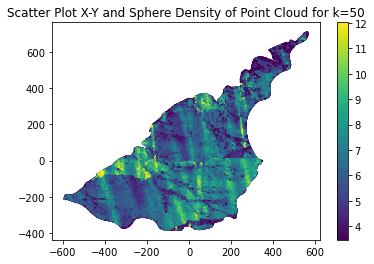

In [42]:
plt.scatter(pc_xyz[::10,0], pc_xyz[::10,1], c=pc_cKDTree_density_sphere[::10], s=1, 
            marker='o', vmin=np.percentile(pc_cKDTree_density_sphere, 2), 
            vmax=np.percentile(pc_cKDTree_density_sphere, 98) )
plt.colorbar()
plt.title('Scatter Plot X-Y and Sphere Density of Point Cloud for k=50')

Define a density function that calculates the density of an ellipsoid. This is computative more intensive, because the x, y, z extent for each point need to be calculated

In [29]:
def pc_density_ellipsoid(pc_xyz, pc_ids, k=10):
    #estimate density in x, y, z directions using an ellipsoid and returning lengthening ratios in x, y, z directions

    x = np.max(pc_xyz[pc_ids,0],axis=1) - np.min(pc_xyz[pc_ids,0],axis=1)
    y = np.max(pc_xyz[pc_ids,1],axis=1) - np.min(pc_xyz[pc_ids,1],axis=1)
    z = np.max(pc_xyz[pc_ids,2],axis=1) - np.min(pc_xyz[pc_ids,2],axis=1)
    dens_ellipsoid = k / (4/3 * np.pi * x * y * z )
    pts_x_y_ratio = x / y #values < 1 indicate X axis is compressed (and Y axis is longer)
    pts_x_z_ratio = x / z #values < 1 indicate X axis is compressed (and Z axis is longer), values > 1 indicate X axis is longer
    pts_y_z_ratio = y / z #values < 1 indicate X axis is compressed (and Z axis is longer), values > 1 indicate X axis is longer
    return dens_ellipsoid, pts_x_y_ratio, pts_x_z_ratio, pts_y_z_ratio


In [51]:
pc_cKDTree_density_ellipsoid, pc_cKDTree_density_ellipsoid_x_y, pc_cKDTree_density_ellipsoid_x_z, pc_cKDTree_density_ellipsoid_y_z = pc_density_ellipsoid(pc_xyz, pc_cKDTree_id, k=50)

In [52]:
wrapped = wrapper(pc_density_ellipsoid, pc_cKDTree_distance, pc_cKDTree_id, 50)
pc_cKDTree_density_ellipsoid_time = timeit.timeit(wrapped, number=3)
print('Average Time: %3.2f s'%(pc_cKDTree_density_ellipsoid_time/3))

Time: 4.94 s


In [53]:
pc_cKDTree_density_ellipsoid

array([2.4706473, 2.0076213, 2.5603588, ..., 1.3098061, 1.4258043,
       1.7411842], dtype=float32)

Text(0.5, 1.0, 'Ellipsoid Density')

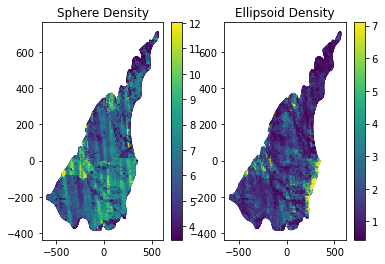

In [54]:
plt.subplot(1, 2, 1)
plt.scatter(pc_xyz[::10,0], pc_xyz[::10,1], c=pc_cKDTree_density_sphere[::10], s=1, 
            marker='o', vmin=np.percentile(pc_cKDTree_density_sphere, 2), 
            vmax=np.percentile(pc_cKDTree_density_sphere, 98) )
plt.colorbar()
plt.title('Sphere Density')

plt.subplot(1, 2, 2)
plt.scatter(pc_xyz[::10,0], pc_xyz[::10,1], c=pc_cKDTree_density_ellipsoid[::10], s=1, 
            marker='o', vmin=np.percentile(pc_cKDTree_density_ellipsoid, 2), 
            vmax=np.percentile(pc_cKDTree_density_ellipsoid, 98) )
plt.colorbar()
plt.title('Ellipsoid Density')


# CUDA Processing
Bring Point Data into CUDA Dataframe. First the X, Y, Z point data and then the ids from the cKDTree run

In [47]:
gdf_float = cudf.DataFrame()
gdf_float['X'] = np.ascontiguousarray(pc_xyz[:,0])
gdf_float['Y'] = np.ascontiguousarray(pc_xyz[:,1])
gdf_float['Z'] = np.ascontiguousarray(pc_xyz[:,2])

print('n_samples = %d, n_dims = %d'%(gdf_float.shape[0], gdf_float.shape[1]))
print(gdf_float)


n_samples = 3348668, n_dims = 3
                  X       Y          Z
0       -591.265625 -199.00 -73.648056
1       -590.421875 -197.75 -73.398056
2       -589.812500 -199.00 -73.178055
3       -589.906250 -198.50 -73.138062
4       -590.578125 -196.75 -73.448059
...             ...     ...        ...
3348663  550.359375  671.50 -24.208061
3348664  551.390625  668.25 -23.178062
3348665  554.437500  671.50 -23.128059
3348666  550.640625  672.50 -24.338058
3348667  550.468750  669.75 -23.808060

[3348668 rows x 3 columns]
n_ids = 3348668, n_dims = 49


In [49]:
pcf_ids = cudf.DataFrame()
pcf_ids = np.ascontiguousarray(pc_cKDTree_id)
print('n_ids = %d, n_dims = %d'%(pcf_ids.shape[0], pcf_ids.shape[1]))

#pcf_d = cudf.DataFrame()
#pcf_d = np.ascontiguousarray(pc_cKDTree_distance)
#print('n_ids = %d, n_dims = %d'%(pcf_d.shape[0], pcf_d.shape[1]))


n_ids = 3348668, n_dims = 49
n_ids = 3348668, n_dims = 49


In [50]:
def pc_density_ellipsoid_CUDA(gdf_float, pcf_ids, k=10):
    #estimate density in x, y, z directions using an ellipsoid and returning lengthening ratios in x, y, z directions

    x = np.max(gdf_float['X'][pcf_ids],axis=1) - np.min(gdf_float[pcf_ids,0],axis=1)
    y = np.max(gdf_float[pcf_ids,1],axis=1) - np.min(gdf_float[pcf_ids,1],axis=1)
    z = np.max(gdf_float[pcf_ids,2],axis=1) - np.min(gdf_float[pcf_ids,2],axis=1)
    dens_ellipsoid = k / (4/3 * np.pi * x * y * z )
    pts_x_y_ratio = x / y #values < 1 indicate X axis is compressed (and Y axis is longer)
    pts_x_z_ratio = x / z #values < 1 indicate X axis is compressed (and Z axis is longer), values > 1 indicate X axis is longer
    pts_y_z_ratio = y / z #values < 1 indicate X axis is compressed (and Z axis is longer), values > 1 indicate X axis is longer
    return dens_ellipsoid, pts_x_y_ratio, pts_x_z_ratio, pts_y_z_ratio


In [63]:
gdf_float['X'].iloc[pcf_ids]

ValueError: Data must be 1-dimensional

In [61]:
pc_xyz[pc_ids,0]

array([[-591.25   , -591.03125, -591.1719 , ..., -589.7344 , -590.625  ,
        -590.6094 ],
       [-590.3281 , -590.59375, -590.0469 , ..., -588.9531 , -588.90625,
        -589.75   ],
       [-589.71875, -589.3594 , -590.28125, ..., -588.6719 , -590.4219 ,
        -588.65625],
       ...,
       [ 554.4531 ,  554.71875,  554.2031 , ...,  555.5625 ,  553.59375,
         553.15625],
       [ 550.65625,  550.8594 ,  550.8906 , ...,  551.625  ,  549.40625,
         549.4219 ],
       [ 550.4531 ,  550.40625,  550.28125, ...,  551.25   ,  549.3125 ,
         549.34375]], dtype=float32)

In [55]:
pcf_density_ellipsoid, pcf_density_ellipsoid_x_y, pcf_density_ellipsoid_x_z, pcf_density_ellipsoid_y_z = pc_density_ellipsoid(gdf_float, pcf_ids, k=50)

TypeError: unhashable type: 'numpy.ndarray'